<a href="https://colab.research.google.com/github/LynnHiuko/Computational_Finance_Methods/blob/main/Miano_Lynn_200664_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIANO LYNN HIUKO  
200664  
MFI 8302  
COMPUTATIONAL METHODS IN FINANCE  
ASSIGNMENT 1  


Q1.  Consider the stochastic volatility process
dS
S
= µdt +
√
vdZS
dv = κv(¯v − v)dt + δv
√
vdZv
where ZS and Zv are correlated Wiener processes so that E(dZSdZv) = ρdt. Simulate the
dynamics for S and v and obtain the distribution for S at t = 1 conditional on the initial stock
price S0.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm


In [8]:
# Setting Parameters
mu = 0.15
v_bar = 0.04
delta_v =0.2
kappa_v = 1
S0= 0.5
T = 1
# N_sim = Number of simulations
N_sim = 10000


In [4]:
# Initial step size of 100 steps
dt = 0.01
N_steps = int(T/dt)

In [5]:
# Simulating correlated Brownian Increments
def simulate_brownian(N_sim, N_steps, dt, rho):

  # Independent normals
  Z1 = np.random.normal(size=(N_sim, N_steps))
  Z2 = np.random.normal(size=(N_sim, N_steps))

  # Correlated increments
  # We use Cholesky decomposition to handle correlation
  dW1 = np.sqrt(dt) * Z1
  dW2 = rho * np.sqrt(dt) * Z1 + np.sqrt(1 - rho**2) * np.sqrt(dt) * Z2

  return dW1, dW2

In [12]:
# Simulate the SDE - Euler-Maruyama (EM)
def simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0,T , N_sim, dt, rho):
  S = np.full(N_sim, S0)
  v = np.full(N_sim, v0)
  for n in range(1, N_steps):
    dW1, dW2 = simulate_brownian(N_sim, N_steps, dt, rho)

    # Updating variance in EM while ensuring non-negativity
    v = np.maximum(v + kappa_v * (v_bar - v) * dt + delta_v * np.sqrt(v) * dW2[:,n], 0)

    # Updating stock price
    S= S * np.exp((mu - 0.5*v)*dt + np.sqrt(v)*dW1[:,n])


  return S, v



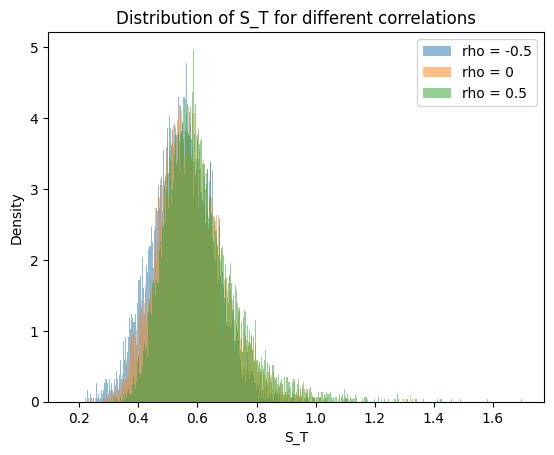

In [14]:
# Run experiments for rho = -0.5,0,0.5
# We start variance at long ruun mean
v0 = v_bar

for rho in [-0.5, 0, 0.5]:
  S_T, v_T = simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0, T, N_sim, dt, rho)

  plt.hist(S_T, bins=500, density=True, alpha=0.5, label=f'rho = {rho}')

plt.legend()
plt.title("Distribution of S_T for different correlations")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.show()

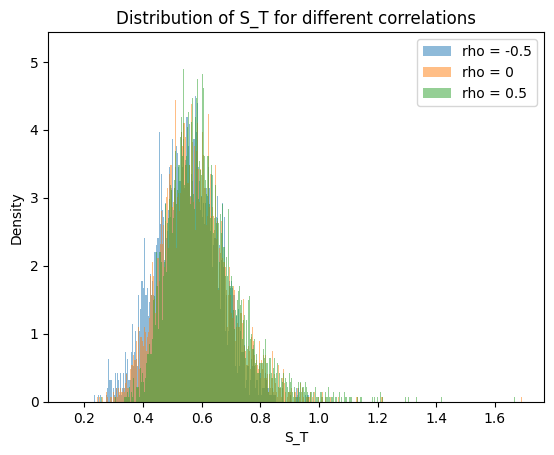

In [15]:
v0 = v_bar

for rho in [-0.5, 0, 0.5]:
  S_T, v_T = simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0, T, N_sim, dt, rho)

  plt.hist(S_T, bins=1000, density=True, alpha=0.5, label=f'rho = {rho}')

plt.legend()
plt.title("Distribution of S_T for different correlations")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.show()

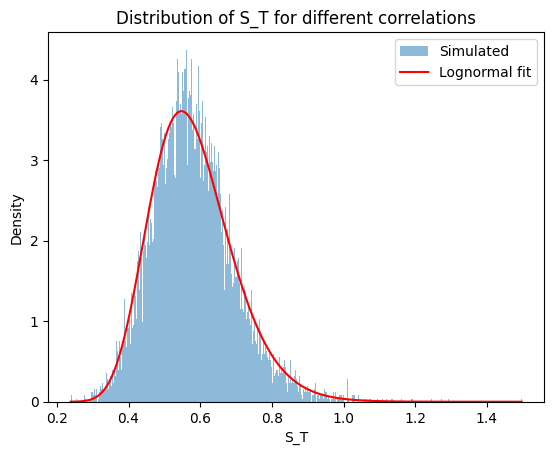

In [20]:
#Compare with lognormal approximation
rho = 0
S_T, v_T = simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0, T, N_sim, dt, rho)

#Calcualting Empirical mean and variance
m, s2 = np.mean(S_T), np.var(S_T)

# Using log normal parameters
sigma_logn = np.sqrt(np.log(1+ s2/m**2))
mu_logn = np.log(m) - 0.5*sigma_logn**2

x = np.linspace(min(S_T), max(S_T), 200)
pdf_logn = lognorm.pdf(x, s=sigma_logn, scale=np.exp(mu_logn))

plt.hist(S_T, bins=500, density=True, alpha=0.5, label="Simulated")
plt.plot(x, pdf_logn, 'r-', label="Lognormal fit")
plt.legend()
plt.title("Distribution of S_T for different correlations")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.show()

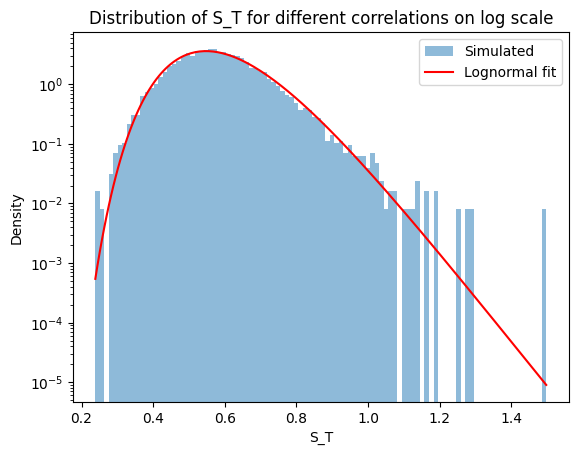

In [21]:
# Plotting the distribution on a log scale
plt.hist(S_T, bins=100, density=True, alpha=0.5, log=True, label="Simulated")
plt.plot(x, pdf_logn, 'r-', label="Lognormal fit")
plt.legend()
plt.title("Distribution of S_T for different correlations on log scale")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.show()

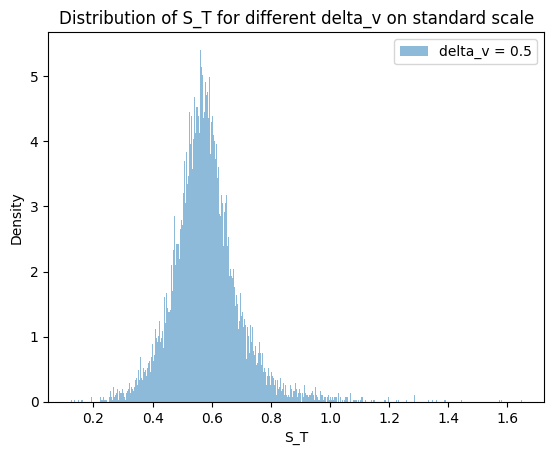

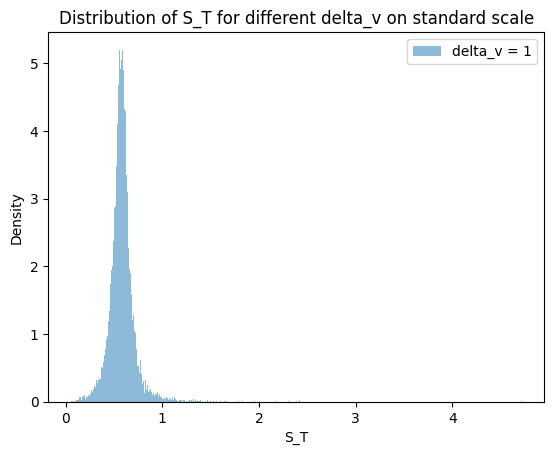

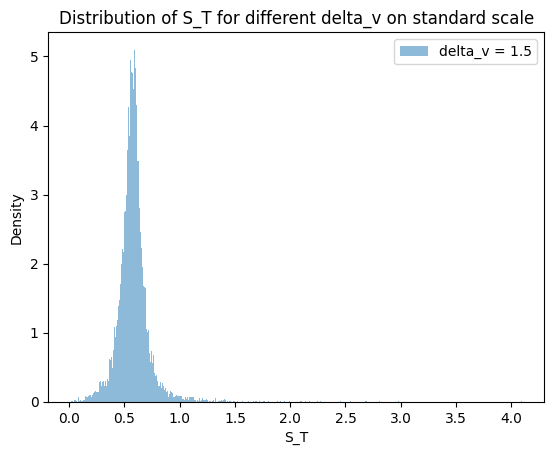

In [23]:
# Experimenting further to gauge the impact of delta
# On Standard scale
for delta_v in [0.5, 1, 1.5]:
  S_T, v_T = simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0, T, N_sim, dt, rho=0)
  plt.hist(S_T, bins=500, density=True, alpha=0.5, label=f'delta_v = {delta_v}')
  plt.legend()
  plt.title("Distribution of S_T for different delta_v on standard scale")
  plt.xlabel("S_T")
  plt.ylabel("Density")
  plt.show()


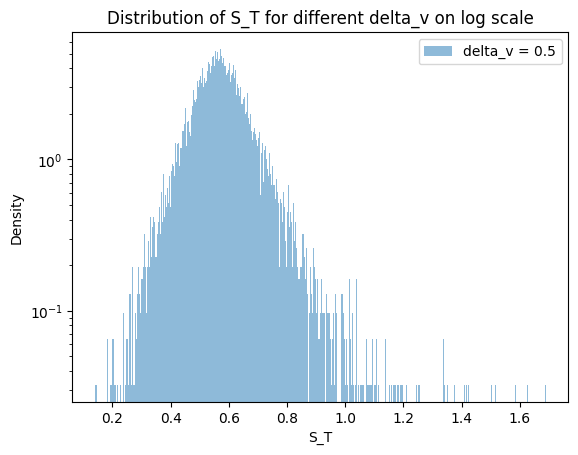

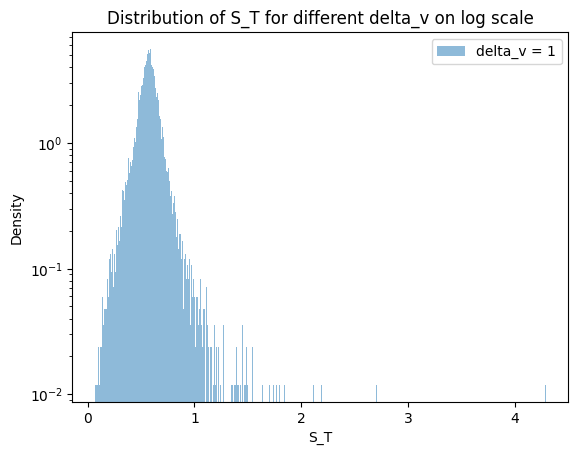

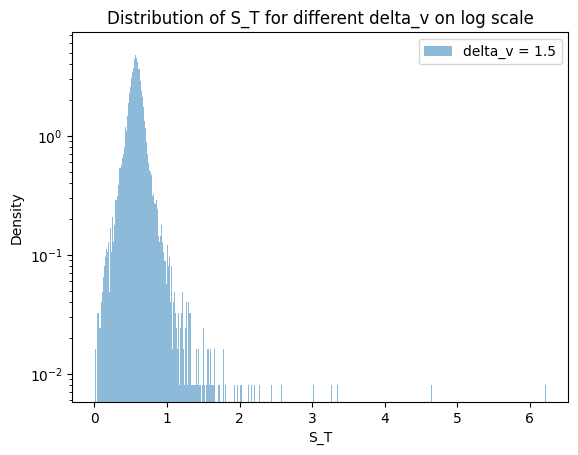

In [24]:
#On Log scale
for delta_v in [0.5, 1, 1.5]:
  S_T, v_T = simulate_paths(mu, v_bar, kappa_v, delta_v, S0, v0, T, N_sim, dt, rho=0)
  plt.hist(S_T, bins=500, density=True, alpha=0.5, log=True, label=f'delta_v = {delta_v}')
  plt.legend()
  plt.title("Distribution of S_T for different delta_v on log scale")
  plt.xlabel("S_T")
  plt.ylabel("Density")
  plt.show()

Q2.  Consider the geometric Brownian motion model under the risk-neutral measure:
dSt
St
= r dt + σ dWt
Simulate the dynamics of the asset price St over the interval t ∈ [0, T], and use Monte Carlo
methods to estimate the price of a European-style average strike Asian call option with
maturity T = 1

(a)  Simulate the paths of St using Euler discretization for geometric Brownian motion

In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

rng = np.random.default_rng(12345)

In [69]:
# Setting parameters
S0 = 100.0
r = 0.05
sigma = 0.2
T = 1.0
#N_mon = Number of monitoring points
N = 50
#Number of Monte Carlo simulations
M = 100000

In [70]:
# Simulate the paths of Stock Price
def simulate_gbm_paths(S0, r, sigma, T, N, M, rng):
  dt = T / N
  S = np.full(M, S0, dtype=float)
  S_paths = np.zeros((M, N), dtype=float)
  for i in range(N):
    Z = rng.standard_normal(M)
    S = S * np.exp((r - 0.5 * sigma**2) *dt +sigma*np.sqrt(dt) *Z)
    S_paths[:,i] = S
  return S_paths

In [71]:
# We carry out a  test
Simulation_test = simulate_gbm_paths(S0, r, sigma, T, N, M, np.random.default_rng())
print("Simulation_test shape:", Simulation_test.shape)


Simulation_test shape: (100000, 50)


In [72]:
print("Mean S_T (empirical)", Simulation_test[:,-1].mean(), "theory", S0*np.exp(r*T))

Mean S_T (empirical) 105.16900643489495 theory 105.12710963760242


In [73]:
#Actual Calculation
def mc_asian_price(S0, r, sigma, T, N, M, rng):
  S_paths = simulate_gbm_paths(S0, r, sigma, T, N, M, rng)

  # Arithmetic average across monitoring points
  S_bar = S_paths.mean(axis=1)

  # Terminal price
  S_T = S_paths[:,-1]
  C_MC = np.exp(-r * T) * np.mean(np.maximum(S_T - S_bar, 0))
  price = C_MC.mean()
  s = C_MC.std()
  se = s / np.sqrt(M)
  z95 = 1.96
  ci = (price - z95 * se, price + z95 * se)
  return price, s, ci


In [74]:
start = time.time()
price_mc, ci_mc, s_mc = mc_asian_price(S0, r, sigma, T, N, M, rng)
end = time.time()
print(f"(a) Plain MC price = {price_mc:.6f}, 95% CI = ({ci_mc[0]:.6f}, {ci_mc[1]:.6f}), std = {s_mc:.6f}")
print("Elapsed:", end - start, "s")

IndexError: invalid index to scalar variable.

In [75]:
# Corrected code

def mc_asian_price(S0, r, sigma, T, N, M, rng):
    S_paths = simulate_gbm_paths(S0, r, sigma, T, N, M, rng)
    S_bar = S_paths.mean(axis=1)
    S_T = S_paths[:, -1]
    discounted_payoffs = np.exp(-r * T) * np.maximum(S_T - S_bar, 0.0)

    price = discounted_payoffs.mean()
    s = discounted_payoffs.std(ddof=1)
    se = s / np.sqrt(M)
    z95 = 1.96
    ci = (price - z95 * se, price + z95 * se)

    return price, ci, s


In [76]:
start = time.time()
price_mc, ci_mc, s_mc = mc_asian_price(S0, r, sigma, T, N, M, rng)
end = time.time()
print(f"(a) Plain MC price = {price_mc:.6f}, 95% CI = ({ci_mc[0]:.6f}, {ci_mc[1]:.6f}), std = {s_mc:.6f}")
print("Elapsed:", end - start, "s")


(a) Plain MC price = 5.784618, 95% CI = (5.732685, 5.836551), std = 8.378951
Elapsed: 0.3156440258026123 s


(b) Improve the estimate using the control variate method.

In [77]:
# Define Y as discounted geometric-average-strike payoff
# Compute arrays from simulated paths
def compute_payoffs_from_paths(S_paths, r, T):
  S_bar = S_paths.mean(axis=1)
  log_S = np.log(S_paths)
  # Calculating the geometric average
  G = np.exp(log_S.mean(axis=1))
  S_T = S_paths[:, -1]
  X = np.exp(-r * T) * np.maximum(S_T - S_bar, 0)
  Y = np.exp(-r * T) * np.maximum(S_T - G, 0)
  return X, Y

In [78]:
# Estiamte mu_Y
def estimate_mu_Y(S0, r, sigma, T, N, M_mu, rng):
  S_paths_mu = simulate_gbm_paths(S0, r, sigma, T, N, M_mu, rng)
  _, Y_mu = compute_payoffs_from_paths(S_paths_mu, r, T)
  mu_Y_estimate = Y_mu.mean()
  return mu_Y_estimate

M_mu = 100_000
mu_Y_estimate = estimate_mu_Y(S0, r, sigma, T, N, M_mu, rng)

In [79]:
# Running the primary simulation
simulate_paths_primary = simulate_gbm_paths(S0, r, sigma, T, N, M, rng)
X_primary, Y_primary = compute_payoffs_from_paths(simulate_paths_primary, r, T)

#Empirical theta
covXY = np.cov(X_primary, Y_primary)[0, 1]
varY = np.var(Y_primary)
theta = covXY / varY

Z = X_primary + theta * (mu_Y_estimate - Y_primary)
# cv=Control Variate
C_cv = np.exp(-r * T) * Z.mean()
s_Z= Z.std()
se_Z = s_Z / np.sqrt(M)
ci_cv = (C_cv - 1.96 * se_Z, C_cv + 1.96 * se_Z)

print("(b) Control variate results:")
print(f" theta = {theta:.6f}")
print(f"CV price = {C_cv:.6f}, 95% CI = ({ci_cv[0]:.6f}, {ci_cv[1]:.6f}), std = {s_Z:.6f}")
print(f" Std of Z = { s_Z:.6f}")

(b) Control variate results:
 theta = 0.967842
CV price = 5.479394, 95% CI = (5.478119, 5.480668), std = 0.205638
 Std of Z = 0.205638


(c)  Compare the two estimates in terms of accuracy and variance


In [85]:
# Variances
var_X = X_primary.var(ddof=1)
var_Z = Z.var(ddof=1)
# Report the percentage reduction in variance
percentage_reduction = 100.0 * (var_X - var_Z) / var_X

print("(c) Comparison:")
print(f" Var(X) = {var_X:.8e}")
print(f" Var(Z) = {var_Z:.8e}")
print(f"Percentage reduction in variance  = {percentage_reduction:.2f}%")



(c) Comparison:
 Var(X) = 7.03984368e+01
 Var(Z) = 4.22876037e-02
Percentage reduction in variance  = 99.94%


(d) Explore how the estimate improves as you vary: N, M, volatility. Plot how the confidence interval narrows as a function of M, and discuss the efficiency ofthe control variate method.



In [81]:
# Estimate improvement
import math

def run_mc_and_vc(S0, r, sigma, T, N, M, rng, MU_Y):
  # Monte Carlo Simulation
  S_paths = simulate_gbm_paths(S0, r, sigma, T,  N, M, rng)
  X, Y = compute_payoffs_from_paths(S_paths, r, T)
  price_mc = X.mean()
  s_X = X.std(ddof=1)
  se_mc = s_mc / math.sqrt(M)

  # Control Variate Technique
  cov_XY = np.cov(X, Y)[0, 1]
  var_Y = np.var(Y)
  theta = cov_XY / var_Y
  Z = X + theta * (mu_Y_estimate - Y)
  price_cv = np.exp(-r * T) * Z.mean()
  s_Z = Z.std(ddof=1)
  se_cv = s_Z / math.sqrt(M)
  return price_mc, se_mc, price_cv, se_cv, s_X**2, s_Z**2, theta





In [82]:
# Simulations
M_list = [ 2000, 5000, 10000, 20000, 50000, 100000]

# Repeat each simualtion 2 times for a smoother estimate
reps = 2
results = []

In [83]:
print("Running Confidence Intervals width vs Number of Simulations experiment")
for M_val in M_list:
 widths_mc = []
 widths_cv = []
 thetas = []
 for rep in range(reps):
    rng_run = np.random.default_rng(12345 + M_val + rep)
    price_mc, se_mc, price_cv, se_cv, var_X, var_Z, theta = run_mc_and_vc(S0, r, sigma, T, N, M_val, rng_run, mu_Y_estimate)
    widths_mc.append(1.96 * se_mc)
    widths_cv.append(1.96 * se_cv)
    thetas.append(theta)
    pass
 results.append({
      'M': M_val,
      'width_mc':np.mean(widths_mc),
      'width_cv': np.mean(widths_cv),
      'theta_mean': np.mean(thetas),
  })

Running Confidence Intervals width vs Number of Simulations experiment


In [84]:
print("M\tCI width (MC)\tCI width (CV)\tmean theta")
for r in results:
    print(f"{r['M']}\t{r['width_mc']:.6f}\t{r['width_cv']:.6f}\t{r['theta_mean']:.6f}")

M	CI width (MC)	CI width (CV)	mean theta
2000	0.367224	0.008973	0.969043
5000	0.232253	0.005910	0.967988
10000	0.164227	0.003997	0.967927
20000	0.116126	0.002845	0.967837
50000	0.073445	0.001821	0.967597
100000	0.051933	0.001286	0.967827


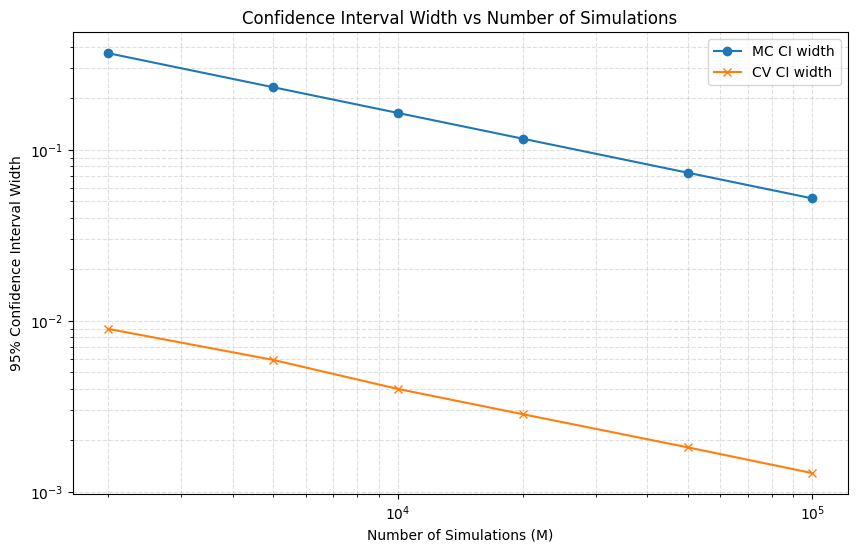

In [86]:
# Plot how the confidence interval narrows as a function of M
Ms = [r['M'] for r in results]
widths_mc = [r['width_mc'] for r in results]
widths_cv = [r['width_cv'] for r in results]

plt.figure(figsize=(10, 6))
plt.loglog(Ms, widths_mc, marker='o', label = 'MC CI width')
plt.loglog(Ms, widths_cv, marker='x', label='CV CI width')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('95% Confidence Interval Width')
plt.title('Confidence Interval Width vs Number of Simulations')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

The control variate technique improves efficiency of Monte Carlo simulation by reducing the estimator's variance without increasing the number of simulated paths.  
The control variate estimator achieves a much narrower confidence interval than plain Monte Carlo for the same computational cost.  
In practice, this translates into a significant variance reduction, meaning we obtain the same accuracy with fewer simulations, making the method highly efficient.